In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text_clean import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

analyser = SentimentIntensityAnalyzer()

def label_stocks(row):
    if row['Close'] >= row['yesterday_close']:
        return 1
    else:
        return 0

def label_sentiment(row):
    sent = analyser.polarity_scores(row['text'])
    return pd.Series([sent['neg'], sent['neu'], sent['pos'], sent['compound']])


# File paths
apple_stocks = "Data/Stock data/aapl_indicators.us.txt"
amazon_stocks = "Data/Stock data/amzn_indicators.us.txt"
facebook_stocks = "Data/Stock data/fb_indicators.us.txt"

apple_headlines = "Data/News data/apple_deduped.csv"
amazon_headlines = "Data/News data/amazon_deduped.csv"
facebook_headlines = "Data/News data/facebook_deduped.csv"

apple_reddit = "Data/Reddit data/apple_reddit.csv"
amazon_reddit = "Data/Reddit data/amazon_reddit.csv"
facebook_reddit = "Data/Reddit data/facebook_reddit.csv"

apple_tweets = "Data/Tweets/apple_tweets.csv"
amazon_tweets = "Data/Tweets/amazon_tweets.csv"
facebook_tweets = "Data/Tweets/facebook_tweets.csv"

# Twitter date parser
mydateparser = lambda x: pd.datetime.strptime(x[:10] + " " + x[-4:], "%a %b %d %Y")

# Read in text data and stock data
df1 = pd.read_csv(apple_headlines, parse_dates=[1])
df2 = pd.read_csv(apple_reddit, parse_dates=[1])
df3 = pd.read_csv(apple_tweets, parse_dates=[1], date_parser=mydateparser)
df = pd.concat([df1, df2, df3], axis=0, join='inner', ignore_index=True)

In [2]:
df = df.set_index(['Date'])

# Limit to 50 headlines per day
df_new = pd.DataFrame()

for _, group in df.groupby(df.index):
    n = 50 if len(group) >= 50 else len(group)
    df_new = pd.concat([df_new, group.sample(n)])
    
df = df_new

# Use NLTK VADER to add sentiment features
df[['neg', 'neu', 'pos', 'compound']] =  df.apply(label_sentiment, axis=1)

# Read stock and technical indicators in
stock = pd.read_csv(apple_stocks, parse_dates=[0])
stock['yesterday_close'] = stock['Close'].shift()
# Label stocks
stock['value'] = stock.apply(lambda row: label_stocks(row), axis=1)
# Shift to get yesterday's values as features
stock.loc[:, 'High':'yesterday_close'] = stock.loc[:, 'High':'yesterday_close'].shift()

In [3]:
# Drop twitter user columns if necessary
# df.drop('user_id_str', axis=1, inplace=True)
df = pd.merge(df, stock, on="Date", how="inner")
df.drop('Close', axis=1, inplace=True)

"""
BALANCE CLASSES
"""
# Class count
count_class_1, count_class_0 = df.value.value_counts()

# Divide by class
df_class_0 = df[df['value'] == 0]
df_class_1 = df[df['value'] == 1]

if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    

df = df.set_index(['Date'])
df.sort_index(inplace=True)

In [4]:
# Scale numeric data
scaler = StandardScaler()
df.loc[:, 'neg': 'yesterday_close'] = scaler.fit_transform(df.loc[:, 'neg': 'yesterday_close'])

Preprocess and split data into train and test sets

In [5]:
# Define feature selectors
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'neg': 'yesterday_close'], validate=False)

# X = features, y = class labels
X = df.loc[:, 'text': 'yesterday_close']
y = df.loc[:, 'value']

In [10]:
from sklearn.dummy import DummyClassifier
# Create model and vectorizer
vect = CountVectorizer(analyzer=preprocess_text, strip_accents='unicode', ngram_range=(1, 3))

model = Pipeline([
    ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)
                ])),
#                   ('text_features', Pipeline([
#                      ('selector', get_text_data),
#                      ('vec',  vect)
#                  ]))
         ])),
    # ('clf', LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=False, loss='hinge', max_iter=3000, penalty='l2'))
    # ('clf', MultinomialNB()),
    ('clf', KNeighborsClassifier(n_neighbors=2)),
])

# Grid Search

In [9]:
# Create custom CV array
X_cv = X.reset_index()
y_cv = y.reset_index()
cv_iterator = []
# Cross Validation
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_date_end = df.index[test_index[-1]]
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    
    # Split
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    train_indices = X_cv.loc[mask_train].index.values
    test_indices = X_cv.loc[mask_test].index.values
    cv_iterator.append((train_indices, test_indices))


In [ ]:
# Choose some parameter combinations to try
# for SVM
parameters = {'clf__penalty': ['l1', 'l2'], 
              'clf__loss': ['hinge', 'squared_hinge'], 
              'clf__dual': [True, False],
              'clf__C': [0.1, 1, 2, 10, 100], 
              'clf__fit_intercept': [False],
              'clf__random_state': [None, 42],
              'clf__max_iter': [1000, 2000, 3000]
             }

# For KNN
# parameters = {'clf__n_neighbors': [2, 3], 
#               'clf__weights': ['uniform', 'distance'], 
#               'clf__n_jobs': [-1],
#              }

# For Vectorizer
# parameters = {'features__text_features__vec__analyzer': ['word', preprocess_text], 
#               'features__text_features__vec__ngram_range': [(1, 1), (1, 2), (1, 3), (3, 3)]
#              }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer, n_jobs=-1, error_score=0.0, cv=cv_iterator, verbose=10)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

In [13]:
grid_obj.best_params_

0.4960053822218485

# Cross-validate model

In [11]:
accs = []
f1s = []
cms = []

X_cv = X.reset_index()
y_cv = y.reset_index()

# Uncomment if you want to use grid search estimator
# try:
#     model = clf
# except:
#     pass

# Cross Validation
kf = KFold(n_splits=10)
run_num = 0
for train_index, test_index in kf.split(X):
    # Calculate train date range
    train_date_begin = df.index[train_index[0]]
    train_date_end = df.index[train_index[-1]]
    train_date_begin = str(train_date_begin.date())
    train_date_end = str(train_date_end.date())
    
    # Calculate test date range
    test_date_begin = df.index[test_index[0]]
    test_train_left = test_date_begin - pd.DateOffset(1)
    
    test_date_end = df.index[test_index[-1]]
    test_train_right = test_date_end + pd.DateOffset(1)
    
    test_date_begin = str(test_date_begin.date())
    test_date_end = str(test_date_end.date())
    print(f"Run #{run_num}")
    print(test_date_begin)
    print(test_date_end)
    
    # Split
    #X_train, X_test = pd.concat([X.loc[train_date_begin:test_train_left], X.loc[test_train_right:train_date_end]]), X.loc[test_date_begin:test_date_end]
    #y_train, y_test = pd.concat([y.loc[train_date_begin:test_train_left], y.loc[test_train_right:train_date_end]]), y.loc[test_date_begin:test_date_end]
    mask_train = ((X_cv['Date'] >= train_date_begin) & (X_cv['Date'] < test_date_begin)) | ((X_cv['Date'] > test_date_end) & (X_cv['Date'] <= train_date_end))
    mask_test = (X_cv['Date'] >= test_date_begin) & (X_cv['Date'] <= test_date_end)
    X_train, X_test = X_cv.loc[mask_train].loc[:, 'text':], X_cv.loc[mask_test].loc[:, 'text':]
    y_train, y_test = y_cv.loc[mask_train]['value'], y_cv.loc[mask_test]['value']
    
    model.fit(X_train, y_train)
    print(f"Model fit: {model.score(X_train, y_train)}")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Fold accuracy: {accuracy}")
    accs.append(accuracy)
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
    run_num += 1

print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

Run #0
2013-12-31
2014-04-01
Model fit: 0.998961805365827
Fold accuracy: 0.6501714845663891
Run #1
2014-04-01
2014-06-12
Model fit: 0.9987401402278703
Fold accuracy: 0.5417066155321189
Run #2
2014-06-12
2014-09-04
Model fit: 0.9989042897058018
Fold accuracy: 0.38439444710387743
Run #3
2014-09-04
2014-11-07
Model fit: 0.9987427571881491
Fold accuracy: 0.45703125
Run #4
2014-11-07
2015-02-03
Model fit: 0.9988497562578736
Fold accuracy: 0.49688249400479617
Run #5
2015-02-03
2015-04-07
Model fit: 0.9988520826500492
Fold accuracy: 0.50830078125
Run #6
2015-04-07
2015-06-10
Model fit: 0.9987400021913005
Fold accuracy: 0.5660919540229885
Run #7
2015-06-10
2015-08-19
Model fit: 0.9986842105263158
Fold accuracy: 0.34205518553758324
Run #8
2015-08-19
2015-10-20
Model fit: 0.9988514548238897
Fold accuracy: 0.5553935860058309
Run #9
2015-10-20
2015-12-31
Model fit: 0.9989059080962801
Fold accuracy: 0.49078564500484967

Average accuracy across folds: 49.93%

Average F1 score across folds: 45.50%

A

## Graphing

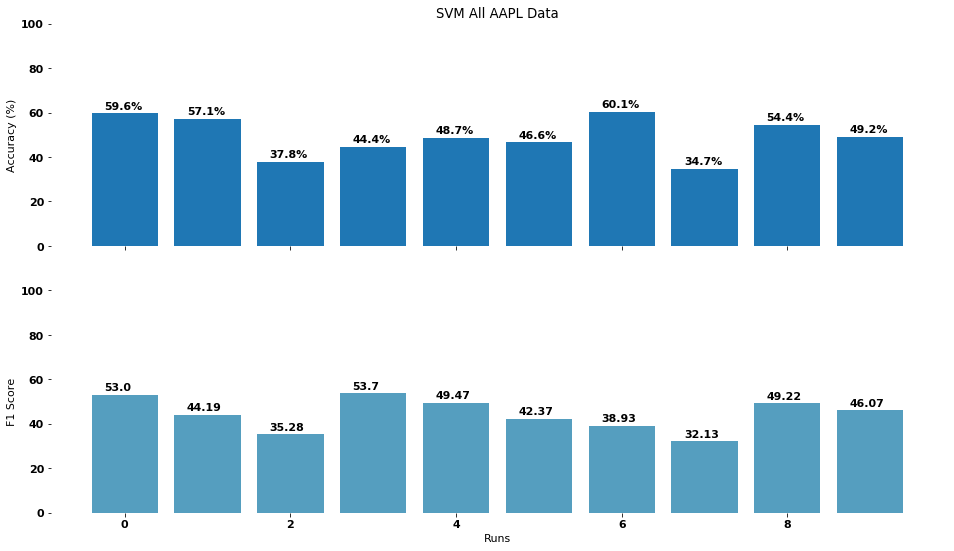

In [90]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('SVM All AAPL Data')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

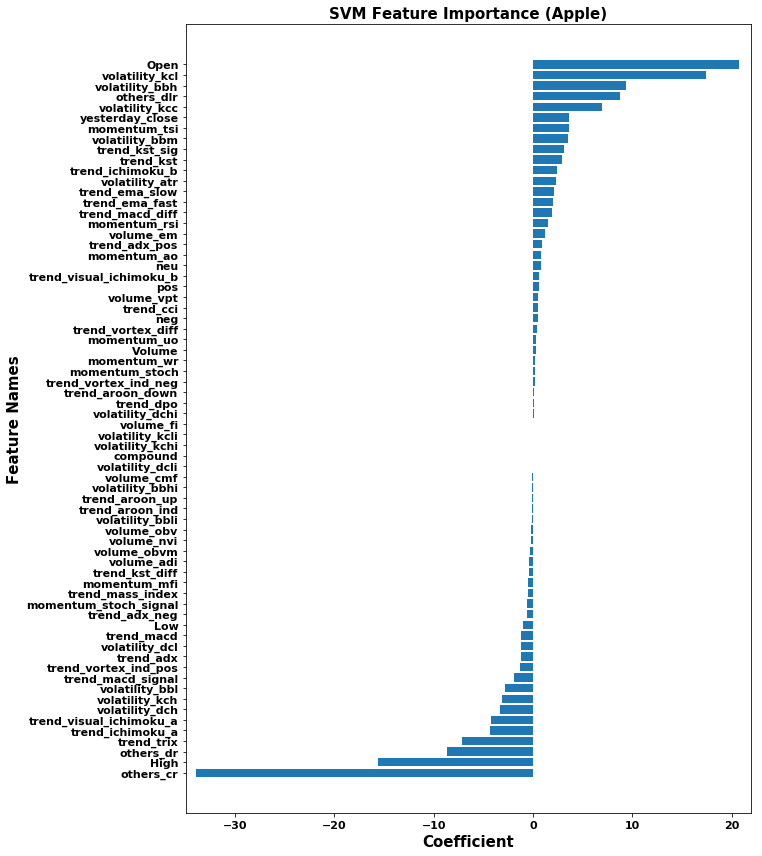

In [81]:
from matplotlib import pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

matplotlib.rc('font', **font)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title('SVM Feature Importance (Apple)', {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15})
    plt.ylabel('Feature Names', {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15})
    plt.xlabel('Coefficient', {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15})
    plt.tight_layout()
    plt.xlim([-35, 22])
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    fig.savefig('feats.png', dpi=100)

features_names = list(df)[1:-1]
f_importances(model.named_steps['clf'].coef_[0], features_names)

# Graph most influential words:

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    """ Get top n tfidf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    """ Plot the data frames returned by the function plot_tfidf_classfeats(). """
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    """ Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    """ Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# model.named_steps['features'].transformer_list[1][1].named_steps['vec']
Xtr = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].fit_transform(X['text'])
features = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].get_feature_names()
feats = top_feats_by_class(Xtr, y, features)

plot_tfidf_classfeats_h(feats)

# Plot ROC Curve along with other stats

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot

def evaluate(classifier):
    predicted = classifier.predict(X_test)
    if isinstance(classifier.steps[1][1], LinearSVC):
        probabilities = np.array(classifier.decision_function(X_test))
        scores = probabilities
    else:
        probabilities = np.array(classifier.predict_proba(X_test))
        scores = probabilities[:, 1]  # NEW

    testing_category_array = np.array(y_test)  # NEW
    pos_idx = np.where(testing_category_array == 1)
    predicted_true_binary = np.zeros(testing_category_array.shape)
    predicted_true_binary[pos_idx] = 1
    fpr, tpr, thresholds = roc_curve(predicted_true_binary, scores)
    auc = roc_auc_score(predicted_true_binary, scores)

    mean_acc = np.mean(predicted == y_test)
    report = classification_report(y_test, predicted)

    return fpr, tpr, auc, mean_acc, report

fpr, tpr, auc, mean_acc, report = evaluate(model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

Decision Boundaries

In [12]:
feats = FeatureUnion([
              ('numeric_features', Pipeline([
                  ('selector', get_numeric_data)
              ])),
#                 ('text_features', Pipeline([
#                    ('selector', get_text_data),
#                    ('vec',  vect)
#                ]))
         ])

data = feats.fit_transform(X_train)

In [13]:
from mlxtend.plotting import plot_decision_regions

tsvd = TruncatedSVD(n_components=2)
# tsvd = TSNE(n_components=2, verbose=1)
pca = tsvd.fit(data)
pca_2d = tsvd.transform(data)

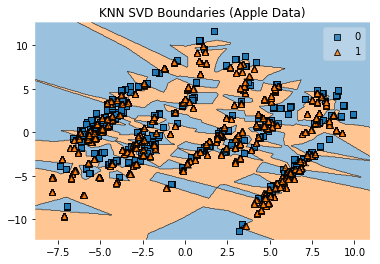

In [14]:
svmClassifier_2d = model.named_steps['clf'].fit(pca_2d, y_train)

plot_decision_regions(X=pca_2d, y=y_train.values, clf=svmClassifier_2d)
# Adding axes annotations
plt.title('KNN SVD Boundaries (Apple Data)')
plt.savefig('KNN_apple.png', dpi=200)